# Import Libraries


In [5]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib import pyplot as  plt 
#import contractions
from bs4 import BeautifulSoup
import unicodedata
import re

from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()



%matplotlib inline

In [6]:
#pip install bs4

In [7]:
#pip install tensorflow_hub


# Import Data

In [8]:
data = pd.read_csv('archive\IMDB DATASET.CSV')

# Sample and visualize the data

In [9]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [11]:
data[data['sentiment'] == 'positive'].head(2).iloc[0].review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [12]:
data[data['sentiment'] == 'positive'].head(2).iloc[1].review

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [13]:
data[data['sentiment'] == 'negative'].head(2).iloc[0].review

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [14]:
data[data['sentiment'] == 'negative'].head(2).iloc[1].review

"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air."

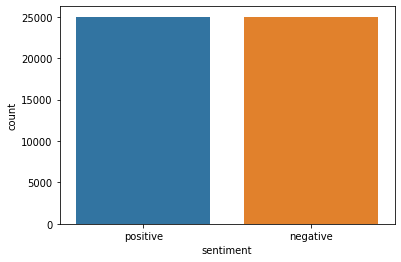

In [15]:
sns.countplot(data['sentiment'] )


# Clean and preprocess

In [33]:


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # strip HTML
    document = strip_html_tags(document)
    # lower case
    document = document.lower()
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    document = remove_accented_chars(document)
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document


pre_process_corpus = np.vectorize(pre_process_document)

# Split data into train and test

In [34]:
X = data['review']
Y=data['sentiment']
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)


X_train, X_test, Y_train,Y_test = train_test_split(X, encoded_Y, test_size=0.3,shuffle= True, random_state=100)

X_train = pre_process_corpus(X_train)
X_test = pre_process_corpus(X_test)



In [20]:
print(X_train.shape, X_test.shape, Y_train.shape,Y_test.shape)

(35000,) (15000,) (35000,) (15000,)


# Create input fuctions for training/testing

In [28]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': X_train}, Y_train, 
    batch_size=256, num_epochs=None, shuffle=True)
    
# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': X_train}, Y_train, shuffle=False)
    
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': X_test}, Y_test, shuffle=False)   

# Use Transfer Learning

In [35]:
hub_module = "https://tfhub.dev/google/nnlm-en-dim128/1"
embedding_feature = hub.text_embedding_column(key='sentence', module_spec=hub_module, trainable=False)

In [23]:
my_checkpointing_config = tf.estimator.RunConfig(
    keep_checkpoint_max = 2,       # Retain the 2 most recent checkpoints.
)

dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
            model_dir='',
            config=my_checkpointing_config)

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpubt2zdej', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 2, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpubt2zdej', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 2, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Train the model

In [29]:
TOTAL_STEPS = 1500
STEP_SIZE = 500
for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
        print('-'*100)
        print('Training for step =', step)
        start_time = time.time()
        dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
        elapsed_time = time.time() - start_time
        print('Train Time (s):', elapsed_time)
        print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
        #print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))


----------------------------------------------------------------------------------------------------
Training for step = 0
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-500


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-500


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 500 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:loss = 85.90956, step = 500


INFO:tensorflow:loss = 85.90956, step = 500


INFO:tensorflow:global_step/sec: 9.60494


INFO:tensorflow:global_step/sec: 9.60494


INFO:tensorflow:loss = 82.73407, step = 600 (10.416 sec)


INFO:tensorflow:loss = 82.73407, step = 600 (10.416 sec)


INFO:tensorflow:global_step/sec: 9.76802


INFO:tensorflow:global_step/sec: 9.76802


INFO:tensorflow:loss = 96.41762, step = 700 (10.253 sec)


INFO:tensorflow:loss = 96.41762, step = 700 (10.253 sec)


INFO:tensorflow:global_step/sec: 9.71042


INFO:tensorflow:global_step/sec: 9.71042


INFO:tensorflow:loss = 95.04882, step = 800 (10.285 sec)


INFO:tensorflow:loss = 95.04882, step = 800 (10.285 sec)


INFO:tensorflow:global_step/sec: 9.31726


INFO:tensorflow:global_step/sec: 9.31726


INFO:tensorflow:loss = 110.856636, step = 900 (10.734 sec)


INFO:tensorflow:loss = 110.856636, step = 900 (10.734 sec)


INFO:tensorflow:Saving checkpoints for 1000 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Loss for final step: 88.8788.


INFO:tensorflow:Loss for final step: 88.8788.


Train Time (s): 75.79097986221313
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-10-11T17:51:33Z


INFO:tensorflow:Starting evaluation at 2020-10-11T17:51:33Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1000


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 19.01425s


INFO:tensorflow:Inference Time : 19.01425s


INFO:tensorflow:Finished evaluation at 2020-10-11-17:51:52


INFO:tensorflow:Finished evaluation at 2020-10-11-17:51:52


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.83414286, accuracy_baseline = 0.50145715, auc = 0.914305, auc_precision_recall = 0.9141736, average_loss = 0.37311614, global_step = 1000, label/mean = 0.49854285, loss = 47.66082, precision = 0.8501744, prediction/mean = 0.48155347, recall = 0.8100751


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.83414286, accuracy_baseline = 0.50145715, auc = 0.914305, auc_precision_recall = 0.9141736, average_loss = 0.37311614, global_step = 1000, label/mean = 0.49854285, loss = 47.66082, precision = 0.8501744, prediction/mean = 0.48155347, recall = 0.8100751


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1000


Eval Metrics (Train): {'accuracy': 0.83414286, 'accuracy_baseline': 0.50145715, 'auc': 0.914305, 'auc_precision_recall': 0.9141736, 'average_loss': 0.37311614, 'label/mean': 0.49854285, 'loss': 47.66082, 'precision': 0.8501744, 'prediction/mean': 0.48155347, 'recall': 0.8100751, 'global_step': 1000}
----------------------------------------------------------------------------------------------------
Training for step = 500
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1000


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1000 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:loss = 97.5612, step = 1000


INFO:tensorflow:loss = 97.5612, step = 1000


INFO:tensorflow:global_step/sec: 10.1981


INFO:tensorflow:global_step/sec: 10.1981


INFO:tensorflow:loss = 100.69023, step = 1100 (9.813 sec)


INFO:tensorflow:loss = 100.69023, step = 1100 (9.813 sec)


INFO:tensorflow:global_step/sec: 10.2572


INFO:tensorflow:global_step/sec: 10.2572


INFO:tensorflow:loss = 101.84375, step = 1200 (9.753 sec)


INFO:tensorflow:loss = 101.84375, step = 1200 (9.753 sec)


INFO:tensorflow:global_step/sec: 10.5157


INFO:tensorflow:global_step/sec: 10.5157


INFO:tensorflow:loss = 98.69953, step = 1300 (9.503 sec)


INFO:tensorflow:loss = 98.69953, step = 1300 (9.503 sec)


INFO:tensorflow:global_step/sec: 10.0632


INFO:tensorflow:global_step/sec: 10.0632


INFO:tensorflow:loss = 101.681145, step = 1400 (9.938 sec)


INFO:tensorflow:loss = 101.681145, step = 1400 (9.938 sec)


INFO:tensorflow:Saving checkpoints for 1500 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:Loss for final step: 121.2508.


INFO:tensorflow:Loss for final step: 121.2508.


Train Time (s): 70.05970931053162
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-10-11T17:53:05Z


INFO:tensorflow:Starting evaluation at 2020-10-11T17:53:05Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1500


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 18.38896s


INFO:tensorflow:Inference Time : 18.38896s


INFO:tensorflow:Finished evaluation at 2020-10-11-17:53:23


INFO:tensorflow:Finished evaluation at 2020-10-11-17:53:23


INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.83897144, accuracy_baseline = 0.50145715, auc = 0.9186641, auc_precision_recall = 0.9182391, average_loss = 0.3634778, global_step = 1500, label/mean = 0.49854285, loss = 46.429646, precision = 0.8489808, prediction/mean = 0.4894453, recall = 0.8234856


INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.83897144, accuracy_baseline = 0.50145715, auc = 0.9186641, auc_precision_recall = 0.9182391, average_loss = 0.3634778, global_step = 1500, label/mean = 0.49854285, loss = 46.429646, precision = 0.8489808, prediction/mean = 0.4894453, recall = 0.8234856


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1500: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1500: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1500


Eval Metrics (Train): {'accuracy': 0.83897144, 'accuracy_baseline': 0.50145715, 'auc': 0.9186641, 'auc_precision_recall': 0.9182391, 'average_loss': 0.3634778, 'label/mean': 0.49854285, 'loss': 46.429646, 'precision': 0.8489808, 'prediction/mean': 0.4894453, 'recall': 0.8234856, 'global_step': 1500}
----------------------------------------------------------------------------------------------------
Training for step = 1000
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1500


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-1500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1500 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:loss = 92.42153, step = 1500


INFO:tensorflow:loss = 92.42153, step = 1500


INFO:tensorflow:global_step/sec: 9.57094


INFO:tensorflow:global_step/sec: 9.57094


INFO:tensorflow:loss = 101.9583, step = 1600 (10.452 sec)


INFO:tensorflow:loss = 101.9583, step = 1600 (10.452 sec)


INFO:tensorflow:global_step/sec: 10.0173


INFO:tensorflow:global_step/sec: 10.0173


INFO:tensorflow:loss = 87.31364, step = 1700 (9.987 sec)


INFO:tensorflow:loss = 87.31364, step = 1700 (9.987 sec)


INFO:tensorflow:global_step/sec: 9.45948


INFO:tensorflow:global_step/sec: 9.45948


INFO:tensorflow:loss = 87.8717, step = 1800 (10.568 sec)


INFO:tensorflow:loss = 87.8717, step = 1800 (10.568 sec)


INFO:tensorflow:global_step/sec: 10.248


INFO:tensorflow:global_step/sec: 10.248


INFO:tensorflow:loss = 97.025375, step = 1900 (9.758 sec)


INFO:tensorflow:loss = 97.025375, step = 1900 (9.758 sec)


INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:Loss for final step: 112.44911.


INFO:tensorflow:Loss for final step: 112.44911.


Train Time (s): 71.50409483909607
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-10-11T17:54:38Z


INFO:tensorflow:Starting evaluation at 2020-10-11T17:54:38Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2000


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 18.19643s


INFO:tensorflow:Inference Time : 18.19643s


INFO:tensorflow:Finished evaluation at 2020-10-11-17:54:56


INFO:tensorflow:Finished evaluation at 2020-10-11-17:54:56


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.84217143, accuracy_baseline = 0.50145715, auc = 0.9220262, auc_precision_recall = 0.9217641, average_loss = 0.35742065, global_step = 2000, label/mean = 0.49854285, loss = 45.655922, precision = 0.85964173, prediction/mean = 0.48038548, recall = 0.8167803


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.84217143, accuracy_baseline = 0.50145715, auc = 0.9220262, auc_precision_recall = 0.9217641, average_loss = 0.35742065, global_step = 2000, label/mean = 0.49854285, loss = 45.655922, precision = 0.85964173, prediction/mean = 0.48038548, recall = 0.8167803


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2000


Eval Metrics (Train): {'accuracy': 0.84217143, 'accuracy_baseline': 0.50145715, 'auc': 0.9220262, 'auc_precision_recall': 0.9217641, 'average_loss': 0.35742065, 'label/mean': 0.49854285, 'loss': 45.655922, 'precision': 0.85964173, 'prediction/mean': 0.48038548, 'recall': 0.8167803, 'global_step': 2000}
----------------------------------------------------------------------------------------------------
Training for step = 1500
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2000


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:loss = 102.352066, step = 2000


INFO:tensorflow:loss = 102.352066, step = 2000


INFO:tensorflow:global_step/sec: 10.0699


INFO:tensorflow:global_step/sec: 10.0699


INFO:tensorflow:loss = 113.92154, step = 2100 (9.939 sec)


INFO:tensorflow:loss = 113.92154, step = 2100 (9.939 sec)


INFO:tensorflow:global_step/sec: 10.2538


INFO:tensorflow:global_step/sec: 10.2538


INFO:tensorflow:loss = 96.850525, step = 2200 (9.749 sec)


INFO:tensorflow:loss = 96.850525, step = 2200 (9.749 sec)


INFO:tensorflow:global_step/sec: 10.2487


INFO:tensorflow:global_step/sec: 10.2487


INFO:tensorflow:loss = 82.40677, step = 2300 (9.761 sec)


INFO:tensorflow:loss = 82.40677, step = 2300 (9.761 sec)


INFO:tensorflow:global_step/sec: 10.3557


INFO:tensorflow:global_step/sec: 10.3557


INFO:tensorflow:loss = 101.336426, step = 2400 (9.657 sec)


INFO:tensorflow:loss = 101.336426, step = 2400 (9.657 sec)


INFO:tensorflow:Saving checkpoints for 2500 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2500 into C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt.


INFO:tensorflow:Loss for final step: 84.04481.


INFO:tensorflow:Loss for final step: 84.04481.


Train Time (s): 70.99244594573975
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-10-11T17:56:11Z


INFO:tensorflow:Starting evaluation at 2020-10-11T17:56:11Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 19.42197s


INFO:tensorflow:Inference Time : 19.42197s


INFO:tensorflow:Finished evaluation at 2020-10-11-17:56:30


INFO:tensorflow:Finished evaluation at 2020-10-11-17:56:30


INFO:tensorflow:Saving dict for global step 2500: accuracy = 0.84674287, accuracy_baseline = 0.50145715, auc = 0.9254558, auc_precision_recall = 0.9251296, average_loss = 0.3485831, global_step = 2500, label/mean = 0.49854285, loss = 44.52704, precision = 0.84097964, prediction/mean = 0.5093607, recall = 0.8540891


INFO:tensorflow:Saving dict for global step 2500: accuracy = 0.84674287, accuracy_baseline = 0.50145715, auc = 0.9254558, auc_precision_recall = 0.9251296, average_loss = 0.3485831, global_step = 2500, label/mean = 0.49854285, loss = 44.52704, precision = 0.84097964, prediction/mean = 0.5093607, recall = 0.8540891


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


Eval Metrics (Train): {'accuracy': 0.84674287, 'accuracy_baseline': 0.50145715, 'auc': 0.9254558, 'auc_precision_recall': 0.9251296, 'average_loss': 0.3485831, 'label/mean': 0.49854285, 'loss': 44.52704, 'precision': 0.84097964, 'prediction/mean': 0.5093607, 'recall': 0.8540891, 'global_step': 2500}


# Predict the train and test results

In [30]:

train_eval_result = dnn.evaluate(input_fn=predict_train_input_fn)
test_eval_result = dnn.evaluate(input_fn=predict_test_input_fn)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-10-11T17:56:33Z


INFO:tensorflow:Starting evaluation at 2020-10-11T17:56:33Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 18.04303s


INFO:tensorflow:Inference Time : 18.04303s


INFO:tensorflow:Finished evaluation at 2020-10-11-17:56:51


INFO:tensorflow:Finished evaluation at 2020-10-11-17:56:51


INFO:tensorflow:Saving dict for global step 2500: accuracy = 0.84674287, accuracy_baseline = 0.50145715, auc = 0.9254558, auc_precision_recall = 0.9251296, average_loss = 0.3485831, global_step = 2500, label/mean = 0.49854285, loss = 44.52704, precision = 0.84097964, prediction/mean = 0.5093607, recall = 0.8540891


INFO:tensorflow:Saving dict for global step 2500: accuracy = 0.84674287, accuracy_baseline = 0.50145715, auc = 0.9254558, auc_precision_recall = 0.9251296, average_loss = 0.3485831, global_step = 2500, label/mean = 0.49854285, loss = 44.52704, precision = 0.84097964, prediction/mean = 0.5093607, recall = 0.8540891


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-10-11T17:56:54Z


INFO:tensorflow:Starting evaluation at 2020-10-11T17:56:54Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 11.76274s


INFO:tensorflow:Inference Time : 11.76274s


INFO:tensorflow:Finished evaluation at 2020-10-11-17:57:06


INFO:tensorflow:Finished evaluation at 2020-10-11-17:57:06


INFO:tensorflow:Saving dict for global step 2500: accuracy = 0.8355333, accuracy_baseline = 0.5034, auc = 0.9172786, auc_precision_recall = 0.9181495, average_loss = 0.3659102, global_step = 2500, label/mean = 0.5034, loss = 46.514008, precision = 0.83116204, prediction/mean = 0.51368666, recall = 0.84492123


INFO:tensorflow:Saving dict for global step 2500: accuracy = 0.8355333, accuracy_baseline = 0.5034, auc = 0.9172786, auc_precision_recall = 0.9181495, average_loss = 0.3659102, global_step = 2500, label/mean = 0.5034, loss = 46.514008, precision = 0.83116204, prediction/mean = 0.51368666, recall = 0.84492123


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: C:\Users\DELL\AppData\Local\Temp\tmpubt2zdej\model.ckpt-2500


In [31]:
print({
      "Model Dir": dnn.model_dir,
      "Training Accuracy": train_eval_result["accuracy"],
      "Test Accuracy": test_eval_result["accuracy"],
      "Training AUC": train_eval_result["auc"],
      "Test AUC": test_eval_result["auc"],
      "Training Precision": train_eval_result["precision"],
      "Test Precision": test_eval_result["precision"],
      "Training Recall": train_eval_result["recall"],
      "Test Recall": test_eval_result["recall"]
    })

{'Model Dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpubt2zdej', 'Training Accuracy': 0.84674287, 'Test Accuracy': 0.8355333, 'Training AUC': 0.9254558, 'Test AUC': 0.9172786, 'Training Precision': 0.84097964, 'Test Precision': 0.83116204, 'Training Recall': 0.8540891, 'Test Recall': 0.84492123}
